**Twitter Sentiment Analysis - A comparative study of LSTMs, GRUs & Conv1D layers in TensorFlow-Keras**

In [ ]:
import json
import tensorflow as tf
import csv
import random
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras import regularizers


embedding_dim = 100
max_length = 16
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
training_size = 160000

corpus = []

In [ ]:
import os
dataset_url = "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv"
fname = os.path.join(os.getcwd(), "twitter-data.csv")
tf.keras.utils.get_file(fname, origin=dataset_url, extract=True)

238944256/238942690 [==============================] - 2s 0us/step


'/content/twitter-data.csv'

In [ ]:
num_sentences = 0
with open('/content/twitter-data.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  for row in reader:
    list_item = []
    list_item.append(row[5])
    label = 0 if row[0] == '0' else 1
    list_item.append(label)
    num_sentences += 1
    corpus.append(list_item)


print(num_sentences)
print(len(corpus))
print(corpus[1])

1600000
1600000
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]


In [ ]:
sentences = []
labels = []
random.shuffle(corpus)

for x in range(training_size):
  sentences.append(corpus[x][0])
  labels.append(corpus[x][1])

training_portion = 0.8
val_limit = 0.9

train_split = int(training_portion * len(sentences))
val_split = int(val_limit * len(sentences))


training_sentences = sentences[: train_split]
training_labels = labels[: train_split]

val_sentences = sentences[train_split: val_split]
val_labels = labels[train_split: val_split]

test_sentences = sentences[val_split:]
test_labels = labels[val_split:]

print(len(sentences), len(labels))
print(len(training_sentences), len(training_labels))
print(len(val_sentences), len(val_labels))
print(len(test_sentences), len(test_labels))

160000 160000
128000 128000
16000 16000
16000 16000


In [ ]:
tokenizer = Tokenizer(oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
vocab_size = len(word_index)
print(word_index, "\n", vocab_size)

training_sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(training_sequences, padding=padding_type, truncating=trunc_type, maxlen=max_length)

val_sequences = tokenizer.texts_to_sequences(val_sentences)
val_padded = pad_sequences(val_sequences, padding=padding_type, truncating=trunc_type, maxlen=max_length)

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt

embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

print(len(embeddings_matrix))

--2020-09-09 12:01:38--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.76.128, 64.233.184.128, 66.102.1.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.76.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M  38.6MB/s    in 7.0s    

2020-09-09 12:01:45 (47.0 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]

118023


Model 0 : Only Embedding layer

In [ ]:
training_labels = np.array(training_labels)
val_labels = np.array(val_labels)

model_0 = tf.keras.Sequential([
      tf.keras.layers.Embedding(input_dim=vocab_size+1, 
                                output_dim=embedding_dim, 
                                input_length=max_length, 
                                weights=[embeddings_matrix],
                                trainable=False),
      tf.keras.layers.GlobalAveragePooling1D(),
      tf.keras.layers.Dense(8, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
])

model_0.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_0.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 16, 100)           11802300  
_________________________________________________________________
global_average_pooling1d_2 ( (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 808       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 11,803,117
Trainable params: 817
Non-trainable params: 11,802,300
_________________________________________________________________


In [ ]:
history_0 = model_0.fit(padded, training_labels, epochs=50, validation_data=(val_padded, val_labels))

Epoch 1/50
4000/4000 [==============================] - 11s 3ms/step - loss: 0.6156 - accuracy: 0.6687 - val_loss: 0.6086 - val_accuracy: 0.6689
Epoch 2/50
4000/4000 [==============================] - 11s 3ms/step - loss: 0.5897 - accuracy: 0.6909 - val_loss: 0.5848 - val_accuracy: 0.6888
Epoch 3/50
4000/4000 [==============================] - 11s 3ms/step - loss: 0.5804 - accuracy: 0.6957 - val_loss: 0.5793 - val_accuracy: 0.6888
Epoch 4/50
4000/4000 [==============================] - 11s 3ms/step - loss: 0.5766 - accuracy: 0.6972 - val_loss: 0.5778 - val_accuracy: 0.6910
Epoch 5/50
4000/4000 [==============================] - 11s 3ms/step - loss: 0.5743 - accuracy: 0.6973 - val_loss: 0.5756 - val_accuracy: 0.6948
Epoch 6/50
4000/4000 [==============================] - 11s 3ms/step - loss: 0.5724 - accuracy: 0.6993 - val_loss: 0.5755 - val_accuracy: 0.6953
Epoch 7/50
4000/4000 [==============================] - 12s 3ms/step - loss: 0.5712 - accuracy: 0.6996 - val_loss: 0.5752 - val_ac

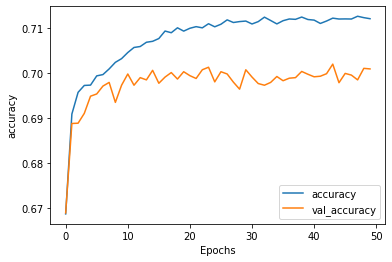

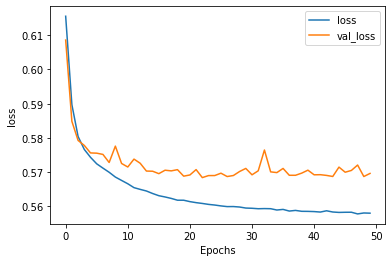

In [ ]:
import matplotlib.pyplot as plt
def plot_graphs(hist, string):
    plt.plot(hist.history[string])
    plt.plot(hist.history['val_' + string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show()

plot_graphs(history_0, "accuracy")
plot_graphs(history_0, "loss")

Model 1 : 1 LSTM


In [ ]:
model_1 = tf.keras.Sequential([
      tf.keras.layers.Embedding(input_dim=vocab_size+1, 
                                output_dim=embedding_dim, 
                                input_length=max_length,
                                weights=[embeddings_matrix],
                                trainable=False),
      tf.keras.layers.LSTM(64),
      tf.keras.layers.Dense(8, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
])

model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_1.summary()

history_1 = model_1.fit(padded, training_labels, epochs=50, validation_data=(val_padded, val_labels))

plot_graphs(history_1, "accuracy")
plot_graphs(history_1, "loss")

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 16, 100)           11802300  
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 11,845,069
Trainable params: 42,769
Non-trainable params: 11,802,300
_________________________________________________________________
Epoch 1/50
4000/4000 [==============================] - 26s 6ms/step - loss: 0.5421 - accuracy: 0.7201 - val_loss: 0.5155 - val_accuracy: 0.7409
Epoch 2/50
4000/4000 [==============================] - 25s 6ms/step - loss: 0.4923 - accu

Model 2 : Bidirectional LSTM

In [ ]:
model_2 = tf.keras.Sequential([
      tf.keras.layers.Embedding(input_dim=vocab_size+1, 
                                output_dim=embedding_dim, 
                                input_length=max_length,
                                weights=[embeddings_matrix],
                                trainable=False),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
      tf.keras.layers.Dense(8, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
])

model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_2.summary()

history_2 = model_2.fit(padded, training_labels, epochs=50, validation_data=(val_padded, val_labels), verbose=2)

plot_graphs(history_2, "accuracy")
plot_graphs(history_2, "loss")

Model 3 : 2 Bidirectional LSTMs

In [ ]:
model_3 = tf.keras.Sequential([
      tf.keras.layers.Embedding(input_dim=vocab_size+1, 
                                output_dim=embedding_dim, 
                                input_length=max_length,
                                weights=[embeddings_matrix],
                                trainable=False),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, num_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
      tf.keras.layers.Dense(8, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
])

model_3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_3.summary()

history_3 = model_3.fit(padded, training_labels, epochs=50, validation_data=(val_padded, val_labels))

plot_graphs(history_3, "accuracy")
plot_graphs(history_3, "loss")

Model 4 : 1 GRU

In [ ]:
model_4 = tf.keras.Sequential([
      tf.keras.layers.Embedding(input_dim=vocab_size+1, 
                                output_dim=embedding_dim, 
                                input_length=max_length,
                                weights=[embeddings_matrix],
                                trainable=False),
      tf.keras.layers.GRU(64),
      tf.keras.layers.Dense(8, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
])

model_4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_4.summary()

history_4 = model_4.fit(padded, training_labels, epochs=50, validation_data=(val_padded, val_labels))

plot_graphs(history_4, "accuracy")
plot_graphs(history_4, "loss")

Model 5 : 1 Bidirectional GRU

In [ ]:
model_5 = tf.keras.Sequential([
      tf.keras.layers.Embedding(input_dim=vocab_size+1, 
                                output_dim=embedding_dim, 
                                input_length=max_length,
                                weights=[embeddings_matrix],
                                trainable=False),
      tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64)),
      tf.keras.layers.Dense(8, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
])

model_5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_5.summary()

history_5 = model_5.fit(padded, training_labels, epochs=50, validation_data=(val_padded, val_labels))

plot_graphs(history_5, "accuracy")
plot_graphs(history_5, "loss")

Model 6 : 2 Bidirectional GRUs

In [ ]:
model_6 = tf.keras.Sequential([
      tf.keras.layers.Embedding(input_dim=vocab_size+1, 
                                output_dim=embedding_dim, 
                                input_length=max_length,
                                weights=[embeddings_matrix],
                                trainable=False),
      tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, num_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64)),
      tf.keras.layers.Dense(8, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
])

model_6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_6.summary()

history_6 = model_6.fit(padded, training_labels, epochs=50, validation_data=(val_padded, val_labels))

plot_graphs(history_6, "accuracy")
plot_graphs(history_6, "loss")

Model 7 : Conv1D layer

In [ ]:
model_7 = tf.keras.Sequential([
      tf.keras.layers.Embedding(input_dim=vocab_size+1, 
                                output_dim=embedding_dim, 
                                input_length=max_length,
                                weights=[embeddings_matrix],
                                trainable=False),
      tf.keras.layers.Conv1D(128, 5, activation='relu'),
      tf.keras.layers.MaxPooling1D(pool_size=4),
      tf.keras.layers.Dense(8, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
])

model_7.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_7.summary()

history_7 = model_7.fit(padded, training_labels, epochs=50, validation_data=(val_padded, val_labels))

plot_graphs(history_7, "accuracy")
plot_graphs(history_7, "loss")